In [12]:
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
from genealogy_aligner.Traversal import Traversal
from genealogy_aligner.Genealogical import Genealogical
import msprime as msp
import matplotlib.pyplot as plt
from genealogy_aligner.ConstraintSatisfaction import backtrack, arc_consistency
from IPython.display import SVG, display
import copy

In [13]:
np.random.seed(724)

families = 2
generations = 2
avg_children = 2.2
ped = Pedigree.simulate_from_founders_with_sex(families, generations, avg_children)
h_graph = ped.get_haplotype_graph()

path = h_graph.sample_path()
tree = path.to_coalescent_tree()

Text(0.5, 1.0, 'Coalescent tree (diploid)')

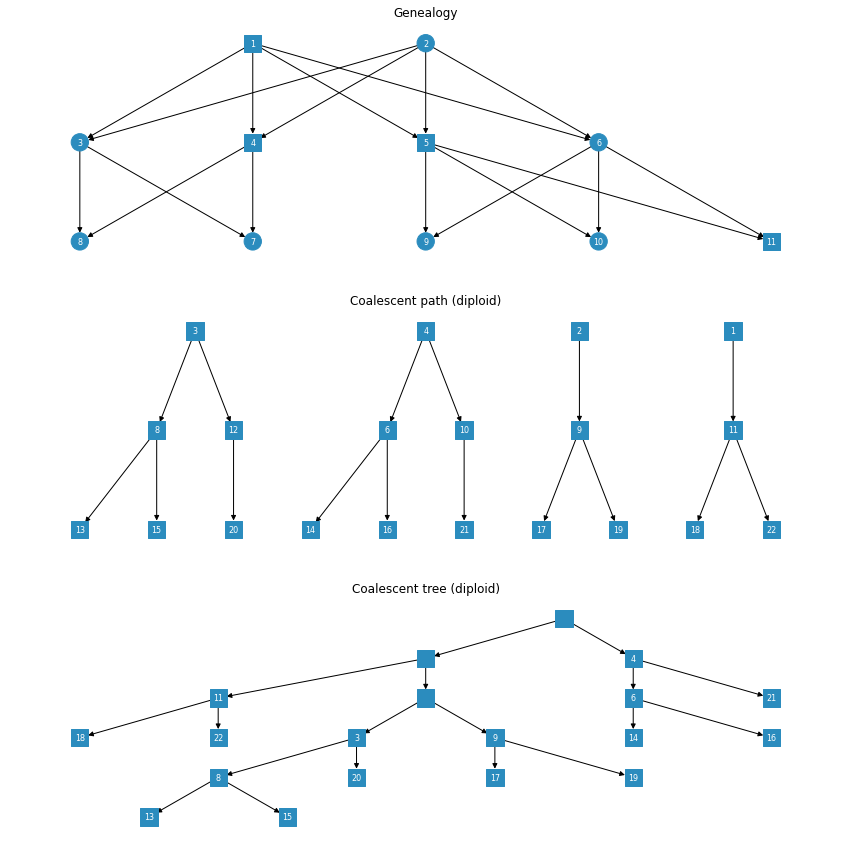

In [14]:
fig, ax = plt.subplots(nrows=3, figsize=(15, 15))

ped.draw(ax=ax[0])
ax[0].set_title('Genealogy')

path.draw(ax=ax[1], label_dict=path.ts_node_to_ped_node)
ax[1].set_title('Coalescent path (diploid)')
tree.draw(ax=ax[2], label_dict=tree.ts_node_to_ped_node)
ax[2].set_title('Coalescent tree (diploid)')

In [18]:
edge_labels = {}
c = 1
for u,v in tree.edges:
    edge_labels[(u,v)] = 'e'+ str(c)
    c = c+1

In [19]:
edge_labels

{(8, 13): 'e1',
 (8, 15): 'e2',
 (6, 14): 'e3',
 (6, 16): 'e4',
 (9, 17): 'e5',
 (9, 19): 'e6',
 (11, 18): 'e7',
 (11, 22): 'e8',
 (3, 8): 'e9',
 (3, 20): 'e10',
 (4, 6): 'e11',
 (4, 21): 'e12',
 (-1, 3): 'e13',
 (-1, 9): 'e14',
 (-2, -1): 'e15',
 (-2, 11): 'e16',
 (-3, 4): 'e17',
 (-3, -2): 'e18'}

In [20]:
pedigree = copy.deepcopy(ped)

In [21]:
coal_edge = {}
for node in tree.nodes:
    if (node not in tree.probands()):
        for succ in tree.successors(node):
            for pred in tree.predecessors(node):
                coal_edge[edge_labels[(node,succ)]]=edge_labels[(pred,node)]
coal_edge

{'e1': 'e9',
 'e2': 'e9',
 'e3': 'e11',
 'e4': 'e11',
 'e5': 'e14',
 'e6': 'e14',
 'e7': 'e16',
 'e8': 'e16',
 'e9': 'e13',
 'e10': 'e13',
 'e11': 'e17',
 'e12': 'e17',
 'e13': 'e15',
 'e14': 'e15',
 'e15': 'e18',
 'e16': 'e18'}

In [22]:
variables = pedigree.nodes

In [23]:
domains = {}
domain = list(edge_labels.values())
domain.append('x')
domain
for v in variables:
    domains[v]=domain

In [24]:
possible_triplets = []

for e in edge_labels.values():
    possible_triplets.append((e,e,'x'))
    possible_triplets.append((e,'x',e))
    possible_triplets.append(('x',e,'x'))
    if e in coal_edge.keys():
        possible_triplets.append((e,coal_edge[e],'x'))
        possible_triplets.append((e,'x',coal_edge[e]))
possible_triplets                

[('e1', 'e1', 'x'),
 ('e1', 'x', 'e1'),
 ('x', 'e1', 'x'),
 ('e1', 'e9', 'x'),
 ('e1', 'x', 'e9'),
 ('e2', 'e2', 'x'),
 ('e2', 'x', 'e2'),
 ('x', 'e2', 'x'),
 ('e2', 'e9', 'x'),
 ('e2', 'x', 'e9'),
 ('e3', 'e3', 'x'),
 ('e3', 'x', 'e3'),
 ('x', 'e3', 'x'),
 ('e3', 'e11', 'x'),
 ('e3', 'x', 'e11'),
 ('e4', 'e4', 'x'),
 ('e4', 'x', 'e4'),
 ('x', 'e4', 'x'),
 ('e4', 'e11', 'x'),
 ('e4', 'x', 'e11'),
 ('e5', 'e5', 'x'),
 ('e5', 'x', 'e5'),
 ('x', 'e5', 'x'),
 ('e5', 'e14', 'x'),
 ('e5', 'x', 'e14'),
 ('e6', 'e6', 'x'),
 ('e6', 'x', 'e6'),
 ('x', 'e6', 'x'),
 ('e6', 'e14', 'x'),
 ('e6', 'x', 'e14'),
 ('e7', 'e7', 'x'),
 ('e7', 'x', 'e7'),
 ('x', 'e7', 'x'),
 ('e7', 'e16', 'x'),
 ('e7', 'x', 'e16'),
 ('e8', 'e8', 'x'),
 ('e8', 'x', 'e8'),
 ('x', 'e8', 'x'),
 ('e8', 'e16', 'x'),
 ('e8', 'x', 'e16'),
 ('e9', 'e9', 'x'),
 ('e9', 'x', 'e9'),
 ('x', 'e9', 'x'),
 ('e9', 'e13', 'x'),
 ('e9', 'x', 'e13'),
 ('e10', 'e10', 'x'),
 ('e10', 'x', 'e10'),
 ('x', 'e10', 'x'),
 ('e10', 'e13', 'x'),
 ('e10', 

In [25]:
diff = []
for e in domain:
    for f in domain:
        if (e != f):
            diff.append((e,f))

In [27]:
constraints = {}
for n in pedigree.nodes:
    par = pedigree.get_parents(n)
    if par[0]!= 0 and par[1]!= 0 :
        constraints.setdefault((n,par[0]), [])
        constraints.setdefault((n,par[1]), [])
        constraints.setdefault((par[0],par[1]), [])
        for t in possible_triplets:
            constraints[(n,par[0])].append((t[0],t[1]))
            constraints[(n,par[1])].append((t[0],t[2]))
            constraints[(par[0],par[1])].append((t[1],t[2]))
constraints

{(3, 1): [('e1', 'e1'),
  ('e1', 'x'),
  ('x', 'e1'),
  ('e1', 'e9'),
  ('e1', 'x'),
  ('e2', 'e2'),
  ('e2', 'x'),
  ('x', 'e2'),
  ('e2', 'e9'),
  ('e2', 'x'),
  ('e3', 'e3'),
  ('e3', 'x'),
  ('x', 'e3'),
  ('e3', 'e11'),
  ('e3', 'x'),
  ('e4', 'e4'),
  ('e4', 'x'),
  ('x', 'e4'),
  ('e4', 'e11'),
  ('e4', 'x'),
  ('e5', 'e5'),
  ('e5', 'x'),
  ('x', 'e5'),
  ('e5', 'e14'),
  ('e5', 'x'),
  ('e6', 'e6'),
  ('e6', 'x'),
  ('x', 'e6'),
  ('e6', 'e14'),
  ('e6', 'x'),
  ('e7', 'e7'),
  ('e7', 'x'),
  ('x', 'e7'),
  ('e7', 'e16'),
  ('e7', 'x'),
  ('e8', 'e8'),
  ('e8', 'x'),
  ('x', 'e8'),
  ('e8', 'e16'),
  ('e8', 'x'),
  ('e9', 'e9'),
  ('e9', 'x'),
  ('x', 'e9'),
  ('e9', 'e13'),
  ('e9', 'x'),
  ('e10', 'e10'),
  ('e10', 'x'),
  ('x', 'e10'),
  ('e10', 'e13'),
  ('e10', 'x'),
  ('e11', 'e11'),
  ('e11', 'x'),
  ('x', 'e11'),
  ('e11', 'e17'),
  ('e11', 'x'),
  ('e12', 'e12'),
  ('e12', 'x'),
  ('x', 'e12'),
  ('e12', 'e17'),
  ('e12', 'x'),
  ('e13', 'e13'),
  ('e13', 'x'),
  ('x'

In [28]:
for n in pedigree.nodes:
    for m in pedigree.nodes:
        if n<m and pedigree.get_parents(n)==pedigree.get_parents(m):
            if pedigree.get_parents(n)!= 0 and pedigree.get_parents(m)!= 0:
                constraints[(n,m)]=diff

In [30]:
ac_result = arc_consistency(variables, domains, constraints)
ac_result

True

In [31]:
backtrack({}, variables, domains, constraints, "MAC")

{1: 'e1', 2: 'e1', 3: 'e2', 4: 'e2', 5: 'e2', 6: 'e2', 7: 'e1', 8: 'e1', 9: 'e1', 10: 'e1', 11: 'e1'}
None
None
None
None
None
None
None
None
None
None
